<a href="https://colab.research.google.com/github/AmirGhnbr/Bit_pred/blob/dev_branch/bit_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance -q

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 5.6 MB/s eta 0:00:00


In [ ]:
!pip3 install --upgrade tensorflow keras-tuner -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TICKER = 'BTC-USD'

In [ ]:
import yfinance as yf
import datetime
import pandas as pd

today = datetime.datetime.now()
start_year_ago = today-datetime.timedelta(days = 720)
btc_data = yf.download(tickers=TICKER, interval="1h",start= start_year_ago, end=today)
btc_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-04-02 08:00:00+00:00,28422.830078,28424.402344,28372.173828,28380.359375,28380.359375,0
2023-04-02 09:00:00+00:00,28381.097656,28434.978516,28370.878906,28411.384766,28411.384766,0
2023-04-02 10:00:00+00:00,28412.289062,28414.642578,28372.988281,28372.988281,28372.988281,0
2023-04-02 11:00:00+00:00,28374.568359,28378.099609,28322.080078,28356.761719,28356.761719,0
2023-04-02 12:00:00+00:00,28356.794922,28360.750000,28257.650391,28271.140625,28271.140625,174867456


In [ ]:
btc_data["OHLC4"] = (btc_data["Open"] + btc_data["High"] + btc_data["Low"] + btc_data["Close"]) / 4 
btc_data.tail()

,Open,High,Low,Close,Adj Close,Volume,OHLC4
Datetime,,,,,,,
2023-04-02 08:00:00+00:00,28422.830078,28424.402344,28372.173828,28380.359375,28380.359375,0,28399.941406
2023-04-02 09:00:00+00:00,28381.097656,28434.978516,28370.878906,28411.384766,28411.384766,0,28399.584961
2023-04-02 10:00:00+00:00,28412.289062,28414.642578,28372.988281,28372.988281,28372.988281,0,28393.227051
2023-04-02 11:00:00+00:00,28374.568359,28378.099609,28322.080078,28356.761719,28356.761719,0,28357.877441
2023-04-02 12:00:00+00:00,28356.794922,28360.750000,28257.650391,28271.140625,28271.140625,174867456,28311.583984


In [ ]:
bitcoin_prices_ohlc4_df = pd.DataFrame(btc_data["OHLC4"]).rename(columns={"OHLC4": "Price"})
bitcoin_prices_ohlc4_df.tail()

,Price
Datetime,
2023-04-02 08:00:00+00:00,28399.941406
2023-04-02 09:00:00+00:00,28399.584961
2023-04-02 10:00:00+00:00,28393.227051
2023-04-02 11:00:00+00:00,28357.877441
2023-04-02 12:00:00+00:00,28311.583984


In [ ]:
def timesteps_and_prices(df):
  '''
  Parameters:
      df: dataframe that contains two columns (Date column, price column)
  output:
      timesteps : in pandas datetime format
      prices: in numpy format
  '''
  timesteps = pd.to_datetime(df.index.to_numpy())
  prices = df["Price"].to_numpy()

  return timesteps, prices


In [ ]:
timesteps, prices = timesteps_and_prices(bitcoin_prices_ohlc4_df)
timesteps[:10], prices[:10]

(DatetimeIndex(['2021-04-12 12:00:00+00:00', '2021-04-12 13:00:00+00:00',
                '2021-04-12 14:00:00+00:00', '2021-04-12 15:00:00+00:00',
                '2021-04-12 16:00:00+00:00', '2021-04-12 17:00:00+00:00',
                '2021-04-12 18:00:00+00:00', '2021-04-12 19:00:00+00:00',
                '2021-04-12 20:00:00+00:00', '2021-04-12 21:00:00+00:00'],
               dtype='datetime64[ns, UTC]', freq=None),
 array([60487.69042969, 60526.47558594, 60255.39257812, 59993.91992188,
        60044.12988281, 59953.51953125, 59975.97558594, 60139.23828125,
        60174.09570312, 60073.32421875]))

## Scale the data

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import RobustScaler

def scale_data(prices):
  scaler = RobustScaler()
  scaled_prices= scaler.fit_transform(prices.reshape(-1, 1))
  scaled_prices= scaled_prices.reshape(1,-1)
  return scaled_prices.squeeze(),scaler
prices, scale_data(prices)

(array([60487.69042969, 60526.47558594, 60255.39257812, ...,
        28393.22705078, 28357.87744141, 28311.58398438]),
 (array([ 1.12281122,  1.12446443,  1.11290959, ..., -0.24520635,
         -0.24671312, -0.24868636]),
  RobustScaler()))

## Split the data

In [ ]:
def get_train_test_split(timesteps,prices, train_test_ratio=0.8):
  '''
  Parameters: 
      timesteps
      prices
  output:
      X_train, y_train, X_test, y_test
  '''
  split_size = int(0.8 * len(prices))
  X_train, y_train = timesteps[:split_size], prices[:split_size]

  X_test, y_test = timesteps[split_size:], prices[split_size:]
  return X_train, y_train, X_test, y_test


In [ ]:
timesteps, prices = timesteps_and_prices(bitcoin_prices_ohlc4_df)
scaled_prices,SCALER = scale_data(prices)
X_train, y_train, X_test, y_test = get_train_test_split(timesteps,scaled_prices)
X_train[:10], y_train[:10]

(DatetimeIndex(['2021-04-12 12:00:00+00:00', '2021-04-12 13:00:00+00:00',
                '2021-04-12 14:00:00+00:00', '2021-04-12 15:00:00+00:00',
                '2021-04-12 16:00:00+00:00', '2021-04-12 17:00:00+00:00',
                '2021-04-12 18:00:00+00:00', '2021-04-12 19:00:00+00:00',
                '2021-04-12 20:00:00+00:00', '2021-04-12 21:00:00+00:00'],
               dtype='datetime64[ns, UTC]', freq=None),
 array([1.12281122, 1.12446443, 1.11290959, 1.10176439, 1.10390458,
        1.10004233, 1.10099952, 1.10795854, 1.10944433, 1.10514898]))

In [ ]:

import matplotlib.pyplot as plt 

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters:
      timesteps : array of timesteps
      values : array of values across time
      format : style of plot, default "."
      start : where to start the plot (setting a value will index from start of timesteps & values)
      end : where to end the plot (setting a value will index from end of timesteps & values)
      label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

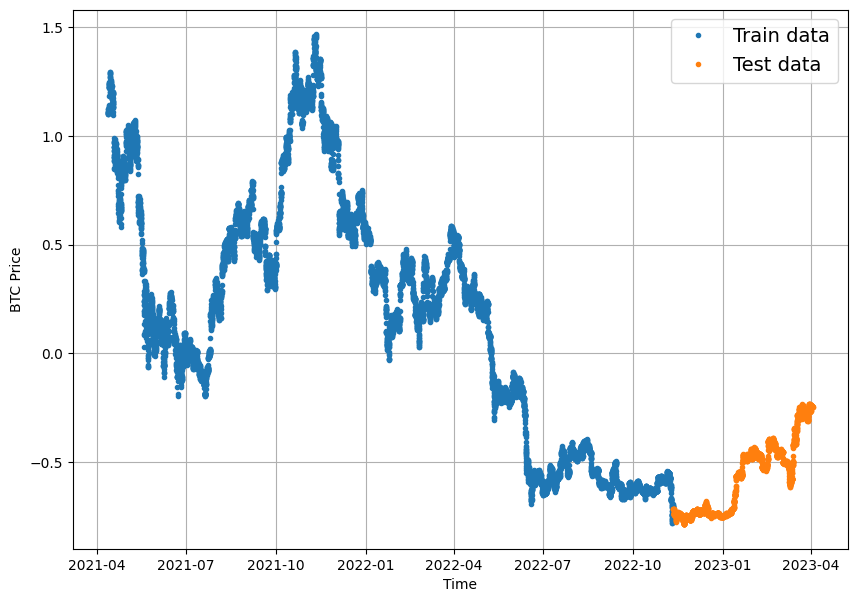

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Define evaluation metrics

In [ ]:
def smape(actual, forecast):
    """
    Calculates Symmetric Mean Absolute Percentage Error (SMAPE) for time series evaluation
    Parameters:
        targets: a numpy array of actual values
        predictions: a numpy array of predicted values
    Returns:
        smape: the SMAPE value
    """
    epsilon = 1e-8
    dividend = tf.abs(actual - forecast)
    denominator = tf.abs(actual) + tf.abs(forecast)
    smape = 200 * tf.reduce_sum(tf.divide(dividend, denominator + epsilon))/tf.size(actual,out_type=tf.float32)
    return smape

In [ ]:
def mape(actual, forecast):
    """
    Calculates Symmetric Mean Absolute Percentage Error (SMAPE) for time series evaluation
    Parameters:
        targets: a numpy array of actual values
        predictions: a numpy array of predicted values
    Returns:
        mape: the SMAPE value
    """
    epsilon = 1e-8
    dividend = tf.abs(actual-forecast)
    denomenator = tf.abs(actual)
    mape = 100*tf.reduce_sum(tf.divide(dividend,denomenator + epsilon))/tf.size(actual,out_type=tf.float32)
    return mape

In [ ]:
def mean_absolute_scaled_error(actual, forecast, horizon=1):
    """
    Parameters:
        actual: numpy array-like with actual values
        forecast: numpy array-like with forecasted values
        horizon: int for the difference between naive forecast and actual value
    Outputs:
        mase: float, mean absolute scaled error
    """
    abs_errors = tf.abs(actual - forecast)

    # Calculate the mean absolute error
    mean_absolute_error = tf.reduce_mean(abs_errors)

    # Calculate the mean absolute error for the naive forecast
    naive_forecast_errors = tf.abs(actual[horizon:] - actual[:-horizon])
    mean_absolute_naive_error = tf.reduce_mean(naive_forecast_errors)

    # Calculate the mean absolute scaled error
    mase = mean_absolute_error / mean_absolute_naive_error

    return mase

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  smape = smape(y_true, y_pred)
  
  if mae.ndim > 0: 
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy(),
          'smape': smape.numpy()}

## Define custom SMAPE metric

In [ ]:
import tensorflow as tf 
class SMAPE(tf.keras.metrics.Metric): 
  def __init__(self, name='smape', **kwargs):
     super(SMAPE, self).__init__(name=name, **kwargs) 
     self.epsilon = 1e-8 
     self.total_smape = self.add_weight(name='total', initializer='zeros') 
     self.counter = self.add_weight(name='counter', initializer='zeros') 
  def update_state(self, y_true, y_pred, sample_weight=None): 
    dividend = tf.abs(y_true - y_pred) 
    denominator = tf.abs(y_true) + tf.abs(y_pred) 
    smape = 200 * tf.divide(dividend, denominator + self.epsilon) 
    self.total_smape.assign_add(tf.reduce_sum(smape)) 
    self.counter.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32)) 
  def result(self): 
    return tf.math.divide_no_nan(self.total_smape, self.counter) 
  def reset_states(self): 
    self.total_smape.assign(0.) 
    self.counter.assign(0.) 

## Window the data

In [ ]:
HORIZON = 24
WINDOW_SIZE= 4*HORIZON

In [ ]:
def get_labelled_windows(x , horizon=1):
  """
  Create labels for windowed dataset
  """
  return x[:,:-horizon] , x[:,-horizon:]

In [ ]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(16947, 16947)

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(13557, 3390, 13557, 3390)

In [ ]:
bit_scaled_df = pd.DataFrame(scaled_prices, columns=['Price'])
bit_scaled_df.head()

,Price
0,1.122811
1,1.124464
2,1.112910
3,1.101764
4,1.103905


In [ ]:
def create_data_window():
    bitcoin_prices_nbeats = bit_scaled_df.copy()
    # bitcoin_prices_nbeats['Price']=bitcoin_prices['Price']
    for i in range(WINDOW_SIZE-1):
      bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
    return bitcoin_prices_nbeats.dropna()

In [ ]:
create_data_window().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,Price+8,Price+9,...,Price+86,Price+87,Price+88,Price+89,Price+90,Price+91,Price+92,Price+93,Price+94,Price+95
95,1.172397,1.151472,1.138736,1.142664,1.129679,1.132572,1.149118,1.167603,1.167619,1.171415,...,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764,1.112910,1.124464,1.122811
96,1.176852,1.172397,1.151472,1.138736,1.142664,1.129679,1.132572,1.149118,1.167603,1.167619,...,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764,1.112910,1.124464
97,1.181161,1.176852,1.172397,1.151472,1.138736,1.142664,1.129679,1.132572,1.149118,1.167603,...,1.109754,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764,1.112910
98,1.176752,1.181161,1.176852,1.172397,1.151472,1.138736,1.142664,1.129679,1.132572,1.149118,...,1.123811,1.109754,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764
99,1.181523,1.176752,1.181161,1.176852,1.172397,1.151472,1.138736,1.142664,1.129679,1.132572,...,1.133222,1.123811,1.109754,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905


In [ ]:
def create_full_datset(windowed_dataset, batch_size=2048):
  drop_list = ['Price' if i==0 else f"Price+{i}" for i in range(HORIZON)]
  X = windowed_dataset.dropna().drop(drop_list, axis=1)
  y = windowed_dataset.dropna()[drop_list]

  split_size = int(len(X) * 0.8)
  X_train, y_train = X[:split_size], y[:split_size]
  X_test, y_test = X[split_size:], y[split_size:]
  len(X_train), len(y_train), len(X_test), len(y_test),X_train.shape

  train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

  # 2. Combine features & labels
  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  # 3. Batch and prefetch for optimal performance
  BATCH_SIZE = batch_size # taken from Appendix D in N-BEATS paper
  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

## Build Nbeats model

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons: int,
               n_layers: int,
               activation: str,
               kernel_initializer: str,
               stack_type: str,
               **kwargs):
    # super().__init__(**kwargs)
    super(NBeatsBlock, self).__init__()
    self.input_size= input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons= n_neurons
    self.n_layers = n_layers
    self.activation = activation
    self.kernel_initializer = kernel_initializer
    self.stack_type = stack_type

    # Block contains stack of 4 fully connected layers each has SeLU activation 
    # But we will use Selu activation with lecun_initializer
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer) for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x)

    if self.stack_type =='trend':
      backcast = theta[:, :self.input_size]
      forecast_coeffs = tf.expand_dims(theta[:,-self.horizon:], axis=2)
      forecast_basis = tf.reshape(tf.range(0, self.horizon - 1, dtype=tf.float32) / self.horizon, (1, 1, -1))
      forecast = tf.reduce_sum(forecast_coeffs * forecast_basis, axis=1)
      return backcast, forecast
    elif self.stack_type == 'seasonality':
      backcast = theta[:, :self.input_size]
      forecast_coeffs = tf.expand_dims(theta[:, -self.horizon:], axis=2)
      
      t = tf.range(0, self.horizon, dtype=tf.float32)

      forecast_basis = tf.add(
        tf.math.cos(2.0 * np.pi * t * tf.reshape(tf.range(1, self.horizon + 1, dtype=tf.float32) / self.horizon, (1, -1))),
        tf.math.sin(2.0 * np.pi * t * tf.reshape(tf.range(1, self.horizon + 1, dtype=tf.float32) / self.horizon, (1, -1)))
      )

      forecast_basis = tf.expand_dims(tf.transpose(forecast_basis), axis=0)
      forecast_basis = tf.tile(forecast_basis, [tf.shape(forecast_coeffs)[0], 1, 1])

      forecast = tf.reduce_sum(forecast_coeffs * forecast_basis, axis=2)
      return backcast, forecast
    else:  
    # Output the backcast and forecast from theta
      backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
      return backcast, forecast
  
  def get_config(self):
    config = super(NBeatsBlock, self).get_config()
    config.update({
        'input_size':self.input_size,
        'theta_size':self.theta_size, 
        'horizon':self.horizon,
        'hidden':self.hidden,
        'n_neurons':self.n_neurons,
        'n_layers':self.n_layers,
        'theta_layer':self.theta_layer,
        'activation' : self.activation,
        'kernel_initializer' :self.kernel_initializer,
        'stack_type':self.stack_type ,

    })
    return config

  

In [ ]:
INPUT_SIZE = WINDOW_SIZE - HORIZON # called "Lookback" in Table 18
# INPUT_SIZE = WINDOW_SIZE
THETA_SIZE = WINDOW_SIZE + HORIZON

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss

class LogCoshLoss(tf.keras.losses.Loss):
    def __init__(self, name="log_cosh_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        """ Compute log-cosh loss between true labels and predicted labels. """
        error = y_pred - y_true
        loss = tf.reduce_mean(tf.math.log(tf.math.cosh(error)))
        return loss

In [ ]:
from tensorflow.keras import layers

def BuildNbeats(architecture_type,tuning_activation,tuning_kernel_initializer,tuning_losses) -> tf.keras.Model:
  '''
  Args:
      architecture_type:str ['nbeats_i','nbeats_g']
      hp: keras tuner
  '''
  if architecture_type == 'nbeats_i':
    NB_SEAS_NEURANS= 2048
    NB_SEAS_BLOCKS=3
    NB_SEAS_LAYERS=4
    NB_TRE_NEURANS = 256
    NB_TRE_BLOCKS = 3
    NB_TRE_BLOCK_LAYERS = 4

    # tuning_activation = hp.Choice('activation', values=['relu', 'selu', 'elu'])
    # tuning_kernel_initializer = hp.Choice('kernel_initializer', values=['lecun_normal','lecun_uniform','glorot_normal','variance_scaling','he_normal'])
    
    ## Trend stack
    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                    theta_size=THETA_SIZE,
                                    horizon=HORIZON,
                                    n_neurons=NB_TRE_NEURANS,
                                    n_layers=NB_TRE_BLOCK_LAYERS,
                                    name="Trend_Block",
                                    stack_type='trend',
                                    activation=tuning_activation,
                                    kernel_initializer=tuning_kernel_initializer)
    stack_input = layers.Input(shape=(INPUT_SIZE), name="trend_stack_input")
    trend_backcast, trend_forecast = nbeats_block_layer(stack_input)
    trend_residuals = layers.subtract([stack_input, trend_backcast], name=f"subtract_00") 

    for i, _ in enumerate(range(NB_TRE_BLOCKS-1)):
      backcast, block_forecast = NBeatsBlock(
            input_size=INPUT_SIZE,
            theta_size=THETA_SIZE,
            horizon=HORIZON,
            n_neurons=NB_TRE_NEURANS,
            n_layers=NB_TRE_BLOCK_LAYERS,
            name="Trend_Block",
            stack_type='trend',
            activation=tuning_activation,
            kernel_initializer=tuning_kernel_initializer,
        )(trend_residuals) 
      trend_residuals = layers.subtract([trend_residuals, backcast], name=f"subtract_trend_{i}") 
      trend_forecast = layers.add([trend_forecast, block_forecast], name=f"add_trend_{i}")

    ## Seasonality stack
    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                    theta_size=THETA_SIZE,
                                    horizon=HORIZON,
                                    n_neurons=NB_SEAS_NEURANS,
                                    n_layers=NB_SEAS_LAYERS,
                                    name="Seasonality_Block",
                                    stack_type='seasonality',
                                    activation=tuning_activation,
                                    kernel_initializer=tuning_kernel_initializer)

    # input_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))(trend_residuals)
    seas_backcast, seas_forecast = nbeats_block_layer(trend_residuals)
    seas_residuals = layers.subtract([trend_residuals, seas_backcast], name=f"seas_subtract_00") 

    for i, _ in enumerate(range(NB_TRE_BLOCKS-1)):
      backcast, block_forecast = NBeatsBlock(
          input_size=INPUT_SIZE,
          theta_size=THETA_SIZE,
          horizon=HORIZON,
          n_neurons=NB_SEAS_NEURANS,
          n_layers=NB_SEAS_LAYERS,
          name=f"SEAS_Block{i}",
          stack_type='seasonality',
          activation=tuning_activation,
          kernel_initializer=tuning_kernel_initializer,
      )(seas_backcast) 


      seas_residuals = layers.subtract([seas_residuals, backcast], name=f"subtract_seas_{i}") 
      seas_forecast = layers.add([seas_forecast, block_forecast], name=f"add_seas_{i}")

    model = tf.keras.Model(inputs=stack_input, 
                         outputs=seas_forecast, 
                         name="model_interpretable_N-BEATS")

    # tuning_losses = hp.Choice('loss',values=[
    #       tf.keras.losses.Huber(),
    #       tf.keras.losses.Hinge(),
    #       custom_exponential_loss,
    #   ])

    model.compile(loss=tuning_losses,
                  optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00025),
                  metrics=["mae", "mse", tf.keras.losses.Huber()])
    return model

  ## elsif  
  elif architecture_type == 'nbeats_g':
    N_NEURONS = 512
    N_LAYERS = 4
    N_STACKS = 30

    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="Initial_g_Block")
    
    stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_g_input")
    backcast, forecast = nbeats_block_layer(stack_input)
    residuals = layers.subtract([stack_input, backcast], name=f"subtract_10") 

    for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
      backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
      )(residuals) # pass it in residuals (the backcast)

      residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
      forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

    model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_Generic_N-BEATS")
    
    # tuning_losses = hp.Choice('loss',values=[
    #       tf.keras.losses.Huber(),
    #       tf.keras.losses.Hinge(),
    #       custom_exponential_loss,
    #   ])

    model.compile(loss=tuning_losses,
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=["mae", "mse", tf.keras.losses.Huber()])
      
    return model


In [ ]:
class custom_huber_loss(tf.keras.losses.Loss):
    def __init__(self, delta=1.0, name='huber_loss'):
        super().__init__(name=name)
        self.delta = delta

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        abs_error = tf.abs(error)
        quadratic = tf.minimum(abs_error, self.delta)
        linear = abs_error - quadratic
        return tf.reduce_mean(0.5 * tf.square(quadratic) + self.delta * linear)


In [ ]:
MODEL_TO_TRAIN='nbeats_i'

In [ ]:
def buildmodel(hp):

  loss_hyp_param = hp.Choice(name = 'loss', values=['LogCoshLoss','mae','custom_huber_loss'])

  if loss_hyp_param == "LogCoshLoss":
            loss_fn = LogCoshLoss()
  elif loss_hyp_param == "mae":
            loss_fn = 'mae'
  else: 
    loss_fn = custom_huber_loss()

  tuning_activation= hp.Choice(name = 'activation', values=['relu', 'selu', 'elu'])
  tuning_kernel_initializer = hp.Choice(name = 'kernel_initializer', values=['lecun_normal','lecun_uniform','glorot_normal','variance_scaling','he_normal'])

  return BuildNbeats(MODEL_TO_TRAIN,tuning_activation, tuning_kernel_initializer,loss_fn)

In [ ]:
train_dataset,test_dataset = create_full_datset(create_data_window())

In [ ]:
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
import os

FOLDER = '/content/drive/MyDrive/bit_pred/'
FILE1 = 'best_interpretable_model'
FILE2 = 'best_generic_model'

if not os.path.isfile(os.path.join(FOLDER, FILE1)):
  print('training interpretable')
  tuner = kt.GridSearch(hypermodel=buildmodel, objective='val_loss',max_trials=45 ,executions_per_trial=1, directory='my_dir', project_name='my_project')
  tuner.search(train_dataset,batch_size=1024, epochs=50, validation_data=(test_dataset))
  best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
  file = open('/content/drive/MyDrive/bit_pred/interpretable_best_prams.txt', 'w')
  file.write(f'{best_hyperparameters.values}'.replace("'", "\""))
  file.close()
  # best_model = tuner.hypermodel.build(best_hyperparameters)
  # best_model.save(f"/content/drive/MyDrive/bit_pred/best_interpretable_model.h5")

elif not os.path.isfile(os.path.join(FOLDER, FILE2)):
  print('training generic')
  MODEL_TO_TRAIN='nbeats_g'
  tuner = kt.GridSearch(hypermodel=buildmodel, objective='val_loss',max_trials=45 ,executions_per_trial=1, directory='my_dir', project_name='my_project')
  tuner.search(train_dataset,batch_size=1024, epochs=50, validation_data=(test_dataset))
  best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
  file = open('/content/drive/MyDrive/bit_pred/generic_best_prams.txt', 'w')
  file.write(f'{best_hyperparameters.values}'.replace("'", "\""))
  file.close()
  # best_model = tuner.hypermodel.build(best_hyperparameters)
  # best_model.save(f"/content/drive/MyDrive/bit_pred/best_generic_model.h5")


Trial 45 Complete [00h 02m 23s]
val_loss: 0.038107749074697495

Best val_loss So Far: 0.00019781287119258195
Total elapsed time: 01h 33m 26s


In [ ]:
file = open('/content/drive/MyDrive/bit_pred/interpretable_best_prams.txt', 'w')
to_write = {'loss': 'LogCoshLoss', 'activation': 'elu', 'kernel_initializer': 'glorot_normal'}
file.write(f"{to_write}".replace("'", "\""))
file.close()

In [ ]:
def load_the_saved_model(full_path, configs):
  loss = configs['loss']
  'LogCoshLoss','mae','custom_huber_loss'
  if loss == 'LogCoshLoss':
    my_h5_saved_model = tf.keras.models.load_model(
      f"{full_path}.h5", 
      custom_objects={'NBeatsBlock': NBeatsBlock,
                      "LogCoshLoss":LogCoshLoss()},
                      compile=False
                     )
    return my_h5_saved_model
  elif loss == 'mae':
    my_h5_saved_model = tf.keras.models.load_model(
      f"{full_path}.h5", 
      custom_objects={'NBeatsBlock': NBeatsBlock,
                      "mae":tf.keras.losses.mae()}
                      ,compile=False)
    return my_h5_saved_model
  else:
    my_h5_saved_model = tf.keras.models.load_model(
      f"{full_path}.h5", 
      custom_objects={'NBeatsBlock': NBeatsBlock,
                      "custom_huber_loss":custom_huber_loss()},
                      compile=False)
    return my_h5_saved_model

  # my_h5_saved_model.summary()
  

In [ ]:
import json
import os
def load_best_hypers_data(filename):

  with open(os.path.join(FOLDER, filename), 'r') as file:
      json_str = file.read()

  data = json.loads(json_str)

  return data

In [ ]:
FOLDER = '/content/drive/MyDrive/bit_pred/'
FILE1 = 'best_interpretable_model'
FILE2 = 'best_generic_model'

In [ ]:
load_best_hypers_data('interpretable_best_prams.txt')


{'loss': 'LogCoshLoss',
 'activation': 'elu',
 'kernel_initializer': 'glorot_normal'}

In [ ]:
loaded_model=load_the_saved_model(os.path.join(FOLDER, FILE1),load_best_hypers_data('interpretable_best_prams.txt'))
loaded_model.summary()

Model: "model_interpretable_N-BEATS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 trend_stack_input (InputLayer)  [(None, 72)]        0           []                               
                                                                                                  
 n_beats_block (NBeatsBlock)    ((None, 72),         246904      ['trend_stack_input[0][0]']      
                                 (None, 23))                                                      
                                                                                                  
 subtract_00 (Subtract)         (None, 72)           0           ['trend_stack_input[0][0]',      
                                                                  'n_beats_block[0][0]']          
                                                                        

In [ ]:
loaded_model.save(f"/content/drive/MyDrive/bit_pred/best_interpretable_model.h5")

In [ ]:
last_time = timesteps[-1]

## Predict the future

In [ ]:
import datetime
def prepare_pred_data(window_size= WINDOW_SIZE):
  today = datetime.datetime.now()
  start_year_ago = today-datetime.timedelta(days = 720)
  btc_data = yf.download(tickers=TICKER, interval="1h",start= start_year_ago, end=today)
  btc_data["OHLC4"] = (btc_data["Open"] + btc_data["High"] + btc_data["Low"] + btc_data["Close"]) / 4 
  bitcoin_prices_ohlc4_df = pd.DataFrame(btc_data["OHLC4"]).rename(columns={"OHLC4": "Price"})

  timesteps, prices = timesteps_and_prices(bitcoin_prices_ohlc4_df)

  scaled_prices, Scaler = scale_data(prices)

  bit_scaled_df = pd.DataFrame(scaled_prices, columns=['Price'])
  bitcoin_prices_nbeats = bit_scaled_df.copy()
    # bitcoin_prices_nbeats['Price']=bitcoin_prices['Price']
  for i in range(WINDOW_SIZE-1):
      bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
  bitcoin_prices_nbeats=bitcoin_prices_nbeats.dropna()

  drop_list = ['Price' if i==0 else f"Price+{i}" for i in range(HORIZON)]
  X = bitcoin_prices_nbeats.dropna().drop(drop_list, axis=1)
  y = bitcoin_prices_nbeats.dropna()[drop_list]

  return X, timesteps[-1],Scaler

In [ ]:
X, last_data_timestep, PRED_SCALER = prepare_pred_data()
X

[*********************100%***********************]  1 of 1 completed


,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30,Price+31,Price+32,Price+33,...,Price+86,Price+87,Price+88,Price+89,Price+90,Price+91,Price+92,Price+93,Price+94,Price+95
95,1.225973,1.227256,1.214629,1.203971,1.212390,1.221340,1.226813,1.233301,1.236087,1.234323,...,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764,1.112910,1.124464,1.122811
96,1.222070,1.225973,1.227256,1.214629,1.203971,1.212390,1.221340,1.226813,1.233301,1.236087,...,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764,1.112910,1.124464
97,1.227046,1.222070,1.225973,1.227256,1.214629,1.203971,1.212390,1.221340,1.226813,1.233301,...,1.109754,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764,1.112910
98,1.220584,1.227046,1.222070,1.225973,1.227256,1.214629,1.203971,1.212390,1.221340,1.226813,...,1.123811,1.109754,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905,1.101764
99,1.225050,1.220584,1.227046,1.222070,1.225973,1.227256,1.214629,1.203971,1.212390,1.221340,...,1.133222,1.123811,1.109754,1.104119,1.105149,1.109444,1.107959,1.101000,1.100042,1.103905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17061,-0.242910,-0.243262,-0.240609,-0.237668,-0.237607,-0.238020,-0.235467,-0.240069,-0.241949,-0.239338,...,-0.249883,-0.252440,-0.248840,-0.245800,-0.245511,-0.244061,-0.246105,-0.247057,-0.246949,-0.243537
17062,-0.242801,-0.242910,-0.243262,-0.240609,-0.237668,-0.237607,-0.238020,-0.235467,-0.240069,-0.241949,...,-0.245683,-0.249883,-0.252440,-0.248840,-0.245800,-0.245511,-0.244061,-0.246105,-0.247057,-0.246949
17063,-0.243009,-0.242801,-0.242910,-0.243262,-0.240609,-0.237668,-0.237607,-0.238020,-0.235467,-0.240069,...,-0.244616,-0.245683,-0.249883,-0.252440,-0.248840,-0.245800,-0.245511,-0.244061,-0.246105,-0.247057
17064,-0.243704,-0.243009,-0.242801,-0.242910,-0.243262,-0.240609,-0.237668,-0.237607,-0.238020,-0.235467,...,-0.245223,-0.244616,-0.245683,-0.249883,-0.252440,-0.248840,-0.245800,-0.245511,-0.244061,-0.246105


In [ ]:
pred = loaded_model.predict(X[-1:])
pred

1/1 [==============================] - 1s 573ms/step


array([[-0.24743068, -0.26067543, -0.24092641, -0.25106952, -0.25173378,
        -0.25105304, -0.24474797, -0.25270668, -0.245785  , -0.24904318,
        -0.24627422, -0.24851869, -0.24364066, -0.2600688 , -0.2477447 ,
        -0.24505149, -0.24542369, -0.24886672, -0.24011411, -0.25124282,
        -0.24810907, -0.24661562, -0.25504985, -0.24085638]],
      dtype=float32)

In [ ]:
last_data_timestep

Timestamp('2023-04-02 12:00:00+0000', tz='UTC')

In [ ]:
from datetime import timedelta
date_list = []
new_date = last_data_timestep

for i in range(HORIZON):
  new_date = new_date + timedelta(hours=1)
  date_list.append(new_date)

date_list

[Timestamp('2023-04-02 13:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 14:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 15:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 16:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 17:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 18:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 19:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 20:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 21:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 22:00:00+0000', tz='UTC'),
 Timestamp('2023-04-02 23:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 00:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 01:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 02:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 03:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 04:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 05:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 06:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 07:00:00+0000', tz='UTC'),
 Timestamp('2023-04-03 08:00:00+0000', tz='UTC'),


In [ ]:
pred_inverted = PRED_SCALER.inverse_transform(pred)
pred_inverted

array([[28341.043, 28030.312, 28493.637, 28255.674, 28240.09 , 28256.06 ,
        28403.98 , 28217.266, 28379.652, 28303.213, 28368.174, 28315.518,
        28429.959, 28044.545, 28333.676, 28396.86 , 28388.129, 28307.352,
        28512.693, 28251.607, 28325.127, 28360.164, 28162.293, 28495.28 ]],
      dtype=float32)

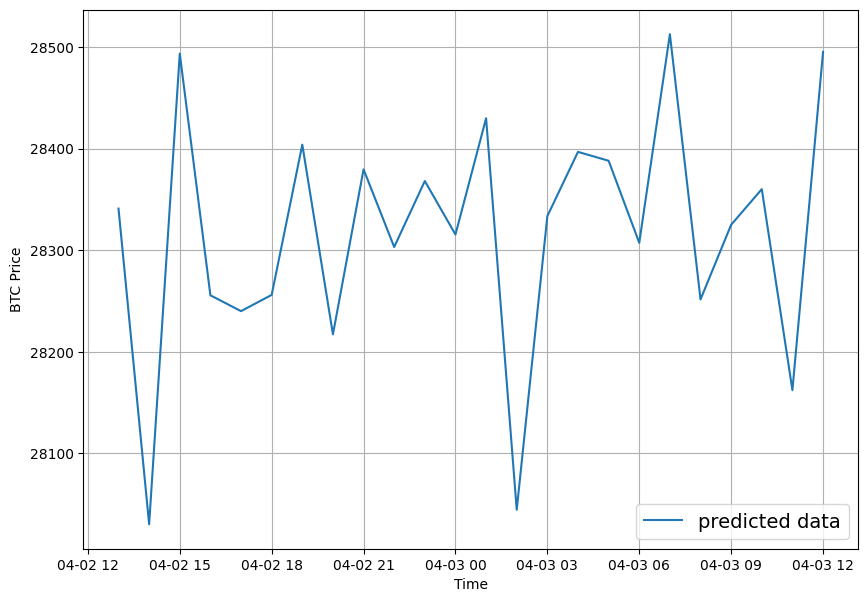

In [ ]:
plt.figure(figsize=(10, 7))
# plot_time_series(pred_timesteps[-10:],pred_prices[-10:], label="original data", format='-')
plot_time_series(date_list,pred_inverted.reshape(-1,1), label="predicted data",format='-')